In [62]:
import torch
import time

# Parameters
N = 30
T = 30 / 365
s0 = 1
sigma = 0.5

# Generate the training set
Train = torch.stack([torch.cat((torch.tensor([s0]),
                                torch.exp(torch.cumsum(- (sigma**2 * T) / (2 * N)
                                + sigma * torch.sqrt(torch.tensor(T / N)) 
                                * torch.randn(N), dim=0)))) for _ in range(10**5)])

# Generate the test set
Test = torch.stack([torch.cat((torch.tensor([s0]),
                               torch.exp(torch.cumsum(- (sigma**2 * T) / (2 * N)
                                + sigma * torch.sqrt(torch.tensor(T / N)) 
                                * torch.randn(N), dim=0)))) for _ in range(10**4)])

In [63]:
# Implement the deep hedging model

nh1 = 64
nh2 = 64
nh3 = 32

networks = [torch.nn.Sequential(
    torch.nn.Linear(1, nh1),
    torch.nn.ReLU(),
    torch.nn.Linear(nh1, nh2),
    torch.nn.ReLU(),
    torch.nn.Linear(nh2, nh3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(nh3, 1)
) for _ in range(N)]

100%|██████████| 100/100 [04:00<00:00,  2.40s/it, loss=8.04e-5]


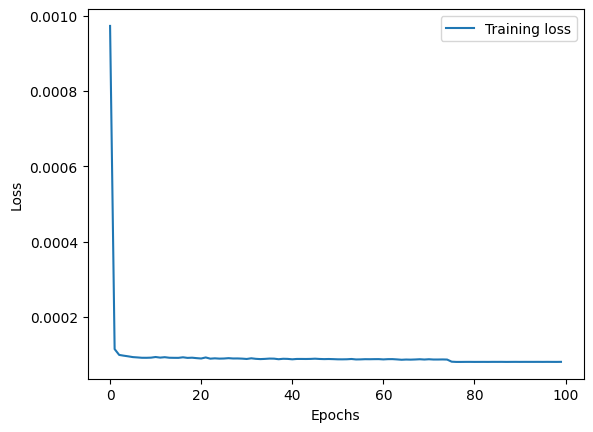

In [64]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
# Implement the payoff function of a call option
K = 1
g = lambda x: torch.relu(x-K)

# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity
def C(x: torch.Tensor, t: float):
    d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(x / K)) + (sigma ** 2 / 2) * (T - t))
    d_minus = d_plus - sigma * torch.sqrt(torch.tensor(T - t))
    return torch.special.ndtr(d_plus) * x - torch.special.ndtr(d_minus) * K

# Train the model
p = C(1,0)
n_epochs = 100
lr = 1e-2
batch_size = 1000
milestones = [75]

# Instantiate an optimizer (i.e. a (Stochastic) Gradient Descent algorithm)
optimizer = torch.optim.Adam([param for network in networks for param in network.parameters()], lr=lr)

# Instantiate a scheduler to decrease the learning rate during training according to a pre-defined rule
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

train_loader = DataLoader(TensorDataset(Train), batch_size=batch_size, shuffle=True)

M1_TST = time.time()
losses = []
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    epoch_loss = 0
    for batch in train_loader:
        batch = batch[0]
        s_T = batch[:, -1]
        H = torch.zeros(batch.size(0),N) 
        optimizer.zero_grad()
        H = torch.stack([networks[i](torch.log(batch[:, i]).unsqueeze(1)).squeeze() for i in range(N)], dim=1)     
        S = batch[:, 1:] - batch[:, :-1]  
        batch_loss = ((g(s_T) - p - torch.sum(H * S, dim=1)) ** 2).mean()
        
        batch_loss.backward()
        optimizer.step()
        

        epoch_loss += batch_loss.item()

    # Average loss per batch
    epoch_loss /= len(train_loader)
    training_loop.set_postfix(loss=epoch_loss)
    
    # Step the scheduler
    scheduler.step()

    # Save training loss for plotting
    losses.append(epoch_loss)
M1_TET = time.time()
# Plot the training loss
plt.plot(losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


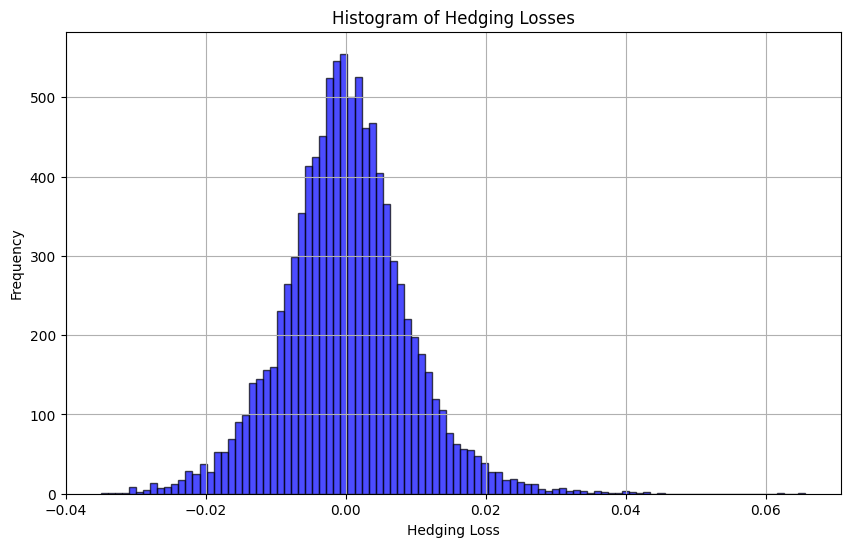

Mean of hedging losses: -0.0000
Standard deviation of hedging losses: 0.0089


In [65]:
# Evaluate the hedging losses on the test set
S_T = Test[:,-1]
H_test = torch.zeros(Test.size(0),N)
for i in range(N):
    input_data = torch.log(Test[:, i]).unsqueeze(1)  
    H_test[:, i] = networks[i](input_data).squeeze()    
S_test = Test[:, 1:] - Test[:, :-1] 
loss = (g(S_T) - p - torch.sum(H_test * S_test, dim=1)).detach()

# Plot a histogram of the hedging losses and print mean and standard deviation

plt.figure(figsize=(10, 6))
plt.hist(loss.numpy(), bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print mean and standard deviation of the losses
mean_loss = torch.mean(loss).item()
std_loss = torch.std(loss).item()
print(f"Mean of hedging losses: {mean_loss:.4f}")
print(f"Standard deviation of hedging losses: {std_loss:.4f}")

/var/folders/1p/fz7nlz5n43x05ck6k83j31340000gn/T/ipykernel_37722/3665163386.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))


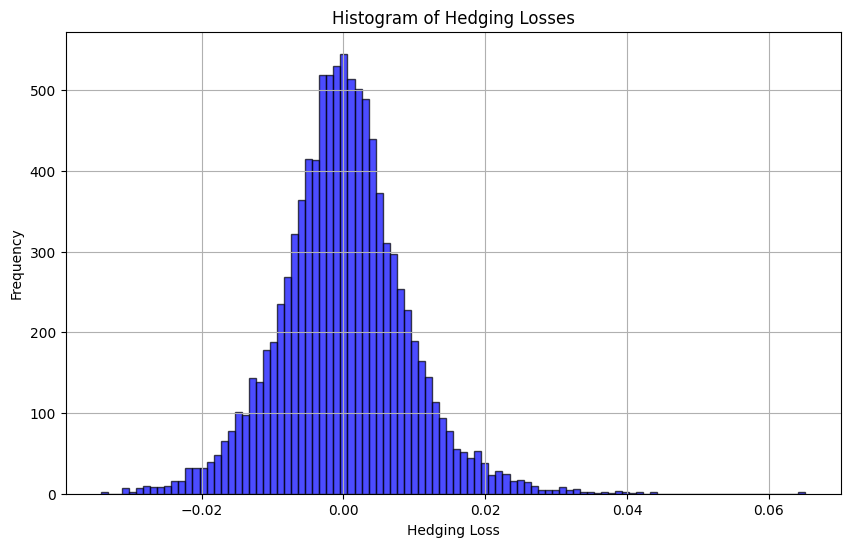

Mean of hedging losses: -0.0000
Standard deviation of hedging losses: 0.0089


In [66]:
from torch.distributions import Normal

def dsC(s: torch.Tensor, t: float):
    d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))
    return torch.special.ndtr(d_plus)



# Evaluate the losses of the analytical hedging strategies on the test set
times = T*torch.arange(0,N)/N
s = Test[:, :-1]
H_analytical = torch.stack([dsC(s[i], times) for i in range(s.size(0))])
analytical_loss = (g(S_T) - p - torch.sum(H_analytical * S_test, dim=1)).detach()

plt.figure(figsize=(10, 6))
plt.hist(analytical_loss, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print mean and standard deviation of the losses
amean_loss = torch.mean(analytical_loss).item()
astd_loss = torch.std(analytical_loss).item()
print(f"Mean of hedging losses: {amean_loss:.4f}")
print(f"Standard deviation of hedging losses: {astd_loss:.4f}")
    


/var/folders/1p/fz7nlz5n43x05ck6k83j31340000gn/T/ipykernel_37722/1165237153.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(s_plot.numpy(),networks[j](torch.log(torch.tensor(s_plot)).unsqueeze(1)).squeeze().detach().numpy(), label=f'$H_{{t_{j}}}$ (NN)', linestyle='--')
/var/folders/1p/fz7nlz5n43x05ck6k83j31340000gn/T/ipykernel_37722/3665163386.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))


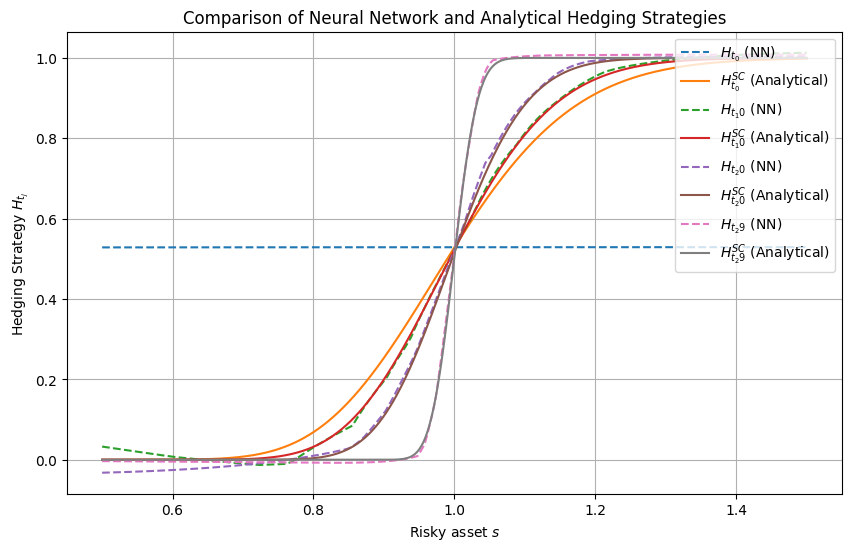

In [67]:
# Ensure s_plot_net and s_plot are defined as per the previous context
s_plot = torch.linspace(0.5, 1.5, 1000)  # Create a range of input prices
s_plot_net = s_plot.view(-1, 1).repeat(1, 30)  # Repeat to match input format for the network

# Time indices for comparison
index = torch.tensor([0, 10, 20, 29])  # Selected time points for plotting

# Create a plot for comparison
plt.figure(figsize=(10, 6))

# Loop over the selected time indices
for j in index:
    # Plot the network's hedging strategy at time t_j
    
    plt.plot(s_plot.numpy(),networks[j](torch.log(torch.tensor(s_plot)).unsqueeze(1)).squeeze().detach().numpy(), label=f'$H_{{t_{j}}}$ (NN)', linestyle='--')

    # Plot the analytical solution at the same time t_j
    plt.plot(s_plot.numpy(), dsC(s_plot, T * j / N).detach().numpy(), label=f'$H^{{SC}}_{{t_{j}}}$ (Analytical)')

# Add plot labels and title
plt.xlabel('Risky asset $s$')
plt.ylabel('Hedging Strategy $H_{t_j}$')
plt.title('Comparison of Neural Network and Analytical Hedging Strategies')
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.show()

In [47]:
# Implement a new deep hedging model
complete_network = torch.nn.Sequential(torch.nn.Linear(2, nh1),
    torch.nn.ReLU(),
    torch.nn.Linear(nh1, nh2),
    torch.nn.ReLU(),
    torch.nn.Linear(nh2, nh3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(nh3, 1)
)


100%|██████████| 100/100 [02:22<00:00,  1.42s/it, loss=8e-5]  


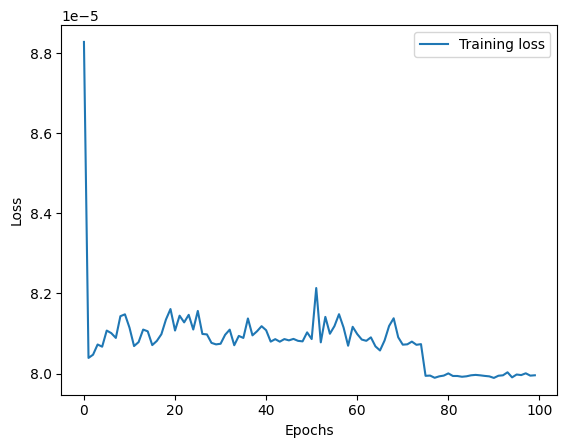

In [68]:
# Train the new deep hedging model


M2_TST = time.time()
# Instantiate an optimizer (i.e. a (Stochastic) Gradient Descent algorithm)
optimizer = torch.optim.Adam(complete_network.parameters(), lr=lr)

# Instantiate a scheduler to decrease the learning rate during training according to a pre-defined rule
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

train_loader = DataLoader(TensorDataset(Train), batch_size=batch_size, shuffle=True)

losses = []
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        batch = batch[0]  
        s_T = batch[:, -1]

        log_S_t = torch.log(batch[:, :-1])
        times = torch.sqrt(T-torch.linspace(0, T, steps=N+1)[:-1]).repeat(batch.shape[0],1)
        inputs = torch.stack((times,log_S_t), dim=2)
    
        
        H = complete_network(inputs).squeeze()

        S = batch[:, 1:] - batch[:, :-1]  

        batch_loss = ((g(s_T) - p - torch.sum(H * S, dim=1)) ** 2).mean() 

        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

    # Average loss per batch
    epoch_loss /= len(train_loader)
    training_loop.set_postfix(loss=epoch_loss)
    
    # Step the scheduler
    scheduler.step()

    # Save training loss for plotting
    losses.append(epoch_loss)
M2_TET = time.time()
# Plot the training loss
plt.plot(losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

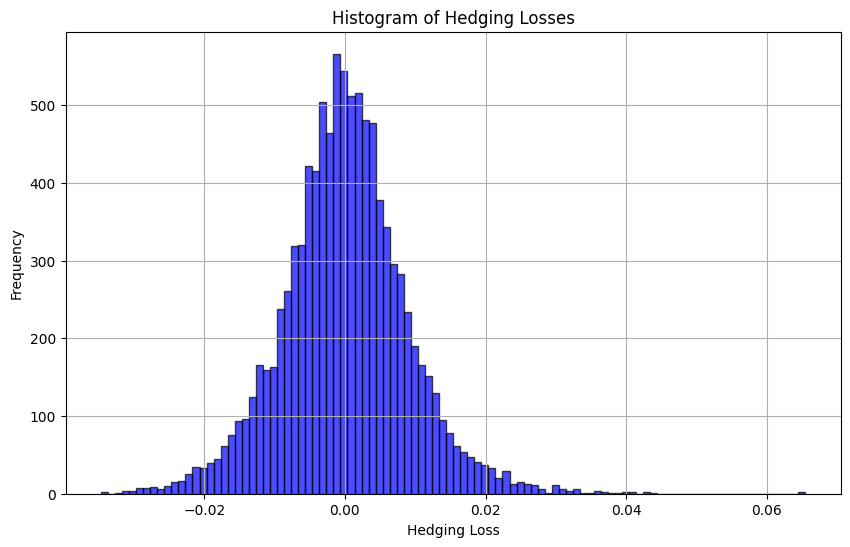

Mean of hedging losses: -0.0000
Standard deviation of hedging losses: 0.0089


In [69]:
import numpy as np
losstest = []
times = torch.linspace(0, T, steps=N+1).unsqueeze(1)
for i in range(10**4):
        # Prepare the inputs for the model
        log_S_t = torch.log(Test[i][:-1]).unsqueeze(1)  # Shape: (num_steps, 1)

        # Combine inputs (log(S_t), t_j) for the model
        inputs = torch.cat((torch.sqrt(T-times[:-1]),log_S_t), dim=1)  # Shape: (num_steps, 2)

        # Predict H_tj using the model
        H = complete_network(inputs)  # Shape: (num_steps, 1)
        # Compute the final loss for this path
        path_loss = g(Test[i][-1]) - p - torch.sum(H.squeeze() * (Test[i][1:] - Test[i][:-1]))
        losstest.append(path_loss.detach())



# Plot a histogram of the hedging losses and print mean and standard deviation

plt.figure(figsize=(10, 6))
plt.hist(losstest, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print mean and standard deviation of the losses
mean_loss = np.mean(losstest)
std_loss = np.std(losstest)
print(f"Mean of hedging losses: {mean_loss:.4f}")
print(f"Standard deviation of hedging losses: {std_loss:.4f}")

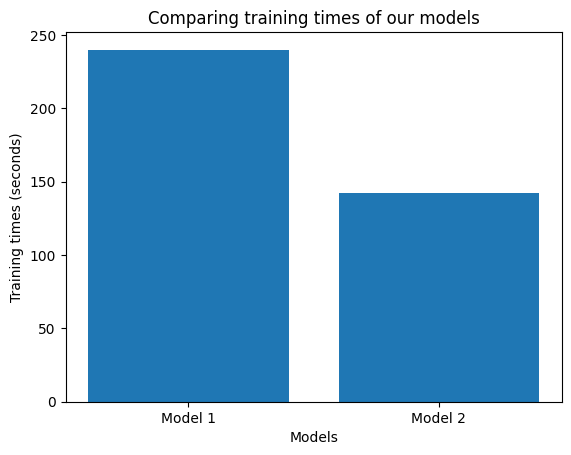

Training time for the first deep heding model:240.01969194412231 seconds.
Training time for the second deep heding model:142.38685488700867 seconds.


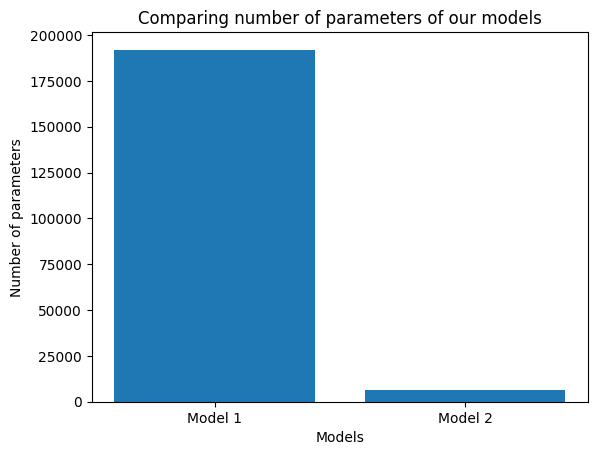

Number of parameters in the first deep hedging model:192030.
Number of parameters in the second deep heding model:6465.


In [70]:
# Compare with the first deep hedging model
# Keep the comparison fair: evaluate run-time, performance and number of parameters.
models = ['Model 1', 'Model 2']
times = [M1_TET - M1_TST, M2_TET - M2_TST]
plt.figure()
plt.bar(models, times)
plt.xlabel('Models')
plt.ylabel('Training times (seconds)')
plt.title('Comparing training times of our models')
plt.show()
print(f'Training time for the first deep heding model:{M1_TET - M1_TST} seconds.')
print(f'Training time for the second deep heding model:{M2_TET - M2_TST} seconds.')

parameters = [sum([param.numel()for network in networks for param in network.parameters()]), sum([param.numel() for param in complete_network.parameters()])]
plt.figure()
plt.bar(models, parameters)
plt.xlabel('Models')
plt.ylabel('Number of parameters')
plt.title('Comparing number of parameters of our models')
plt.show()



print(f'Number of parameters in the first deep hedging model:{sum([param.numel()for network in networks for param in network.parameters()])}.')
print(f'Number of parameters in the second deep heding model:{sum([param.numel() for param in complete_network.parameters()])}.')
